In [ ]:
%%shell
jupyter nbconvert --to html NOTEBOOK_NAME_HERE.ipyn

Link to the Google Colab Notebook: https://colab.research.google.com/drive/1uUt-V6Ij0e5JR4yRNGtlxPgqrT0-QMWp?usp=sharing

# Project Report: Image Describer for Visually Impaired Individuals



---

# Project Overview

The Image Describer project aims to create a system that helps visually impaired individuals understand images by converting them into descriptive audio feedback. This is achieved using advanced machine learning techniques to generate textual captions for images, which are then converted into spoken words.

### Image Captioning
Image captioning is the process of generating a textual description of an image. It utilizes both Natural Language Processing and Computer Vision to generate the captions. This task lies at the intersection of computer vision and natural language processing. Most image captioning systems use an encoder-decoder framework, where an input image is encoded into an intermediate representation of the information in the image, and then decoded into a descriptive text sequence.

### CNNs + RNNs (LSTMs)
To perform image captioning, two deep learning models are combined into one for training purposes:

- **CNNs (Convolutional Neural Networks)** extract features from the image into a vector representation, also known as embeddings. The size of these embeddings depends on the type of pretrained network being used for feature extraction.
- **RNNs (Recurrent Neural Networks), specifically LSTMs (Long Short-Term Memory networks)**, are used for the text generation process. The image embeddings are concatenated with the word embeddings and passed to the LSTM to generate the next word in the sequence.

For a more illustrative explanation of this architecture, refer to the Modeling section for a picture representation.

<img src="https://miro.medium.com/max/1400/1*6BFOIdSHlk24Z3DFEakvnQ.png">


## Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
!pip install gTTS

In [ ]:
import os  # when loading file paths
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil
import pandas as pd  # for lookup in annotation file
import spacy  # for tokenizer
import torch
from torch.nn.utils.rnn import pad_sequence  # pad batch
from torch.utils.data import DataLoader, Dataset
from PIL import Image  # Load img
import torchvision.transforms as transforms
import torch.nn as nn
import statistics
import torchvision.models as models
from tqdm import tqdm
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler
from gtts import gTTS
import IPython.display as ipd
import random
from torchtext.data.metrics import bleu_score
import time

# **Dataset Loading and Visualization**

Images and their corresponding captions from the flicker8k Dataset used in this project to train models.

For furthere reference to the dataset: https://www.kaggle.com/datasets/adityajn105/flickr8k

### Data Loading and Preprocessing

#### 1. Data Source Mapping

- **Description**: This variable contains mappings for two datasets, namely 'flickr-image-dataset' and 'flickr8k', along with their corresponding download URLs. Each dataset is associated with a Google Cloud Storage link that points to a compressed archive file.
- **Usage**: The download URLs are encoded and separated by a comma. During data loading, this variable is used to iterate over each data source, download the respective archive file, and extract its contents.

#### 2. Kaggle Paths and Setup

- **Description**: This section defines the paths for input data, working directory, and the Kaggle symlink. It also ensures the setup of necessary directories and symlinks.
- **Steps**:
  1. Define the paths for Kaggle input and working directories.
  2. Remove any existing Kaggle input directory and create a new one.
  3. Create the Kaggle symlink for input and working directories.

#### 3. Data Download and Extraction

- **Description**: This loop iterates over each data source mapping, downloads the corresponding archive file, and extracts its contents into the Kaggle input directory.
- **Steps**:
  1. Split each data source mapping into directory name and download URL.
  2. Decode the download URL and extract the filename.
  3. Download the file, track download progress, and extract its contents.
  4. Handle exceptions for HTTP errors or file extraction failures.

#### Image Processing Functions

#### 1. `readImage` Function

- **Description**: This function reads an image file from the specified path and resizes it to the given dimensions.
- **Parameters**:
  - `path`: Path to the image file.
  - `img_size`: Size to which the image should be resized (default: 224).
- **Returns**: Processed image as a NumPy array.

#### 2. `display_images` Function

- **Description**: This function displays a grid of images along with their corresponding captions.
- **Parameters**:
  - `temp_df`: DataFrame containing image filenames and captions.
- **Usage**: Utilized to visualize a subset of images and their captions during exploratory data analysis.
- **Steps**:
  1. Reset the index of the DataFrame for proper iteration.
  2. Plot a grid of images with captions, adjusting spacing for better visualization.

In [ ]:
CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'flickr-image-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F31296%2F39911%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240404%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240404T061511Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dacb1efe90deacdfa61b9baa09969dad57cb596b726d8cbc81514fc81e1ae94e86ecb1d4b9d41ab168299bc969ab6fbce82f9e2e80126642db4e1c83961b51580f16642cc143be69c0514af1282da1da39a6610cda5139ca7debfdac1fa57fe50484a9c8b99b397bf433694e6d94870fa2e1184ac1b289b4a109975fa6247368c3340b99b6fe837d70239cb59075e5103350b93e6a744e1843374aef9af9644e1a1757398049762e90715b78f6de45811d8835d502f3245597a921d59e60aa79ba57bc85ad84f8f5558e912a6c93644eba83d3064b3c30581248e4475cbe4ce0df123bd78b806eb01f5017f59cf7a9a83267da49a581352d56a05cc7fd3ea5b42,flickr8k:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F623289%2F1111676%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240404%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240404T061512Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7942f60758f67c02fa169eb0ab3c79b832f9d1fcd6359773dbd6cecb76463d1b290f507c95f66ae87a0964b2393da695ad5bf029ac7af37c6d5cf45c879d6b37606652d1a137723f81619f534c89e91def8d080fa2bcfbd9e9d19c2efc8eedf7694285159384ebe082c02c29c24c2893236950f0997a128fedfc38660972f4a30646179921203b80caa91be845b3cba796793336c69fba172edfc599cf94a5956940971adf35d64b96a4fa5b6bf593f141e8919ca9d76611149285aa0980f8181be67c80d6a609dc19d17e7a3c289b1e5fbd336c03c3ca35d7522b04de4fad9be7ce94bfc850cf242accf36531aaefe90403e13b4faa8c52ddbcab0f67fa06b6'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 8765396518 bytes downloaded
Downloaded and uncompressed: flickr-image-dataset
[==================================================] 1112971163 bytes downloaded
Downloaded and uncompressed: flickr8k
Data source import complete.


In [ ]:
image_path = '../input/flickr8k/Images'

In [ ]:
data = pd.read_csv("../input/flickr8k/captions.txt")
data.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

In [ ]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.

    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"../input/flickr8k/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

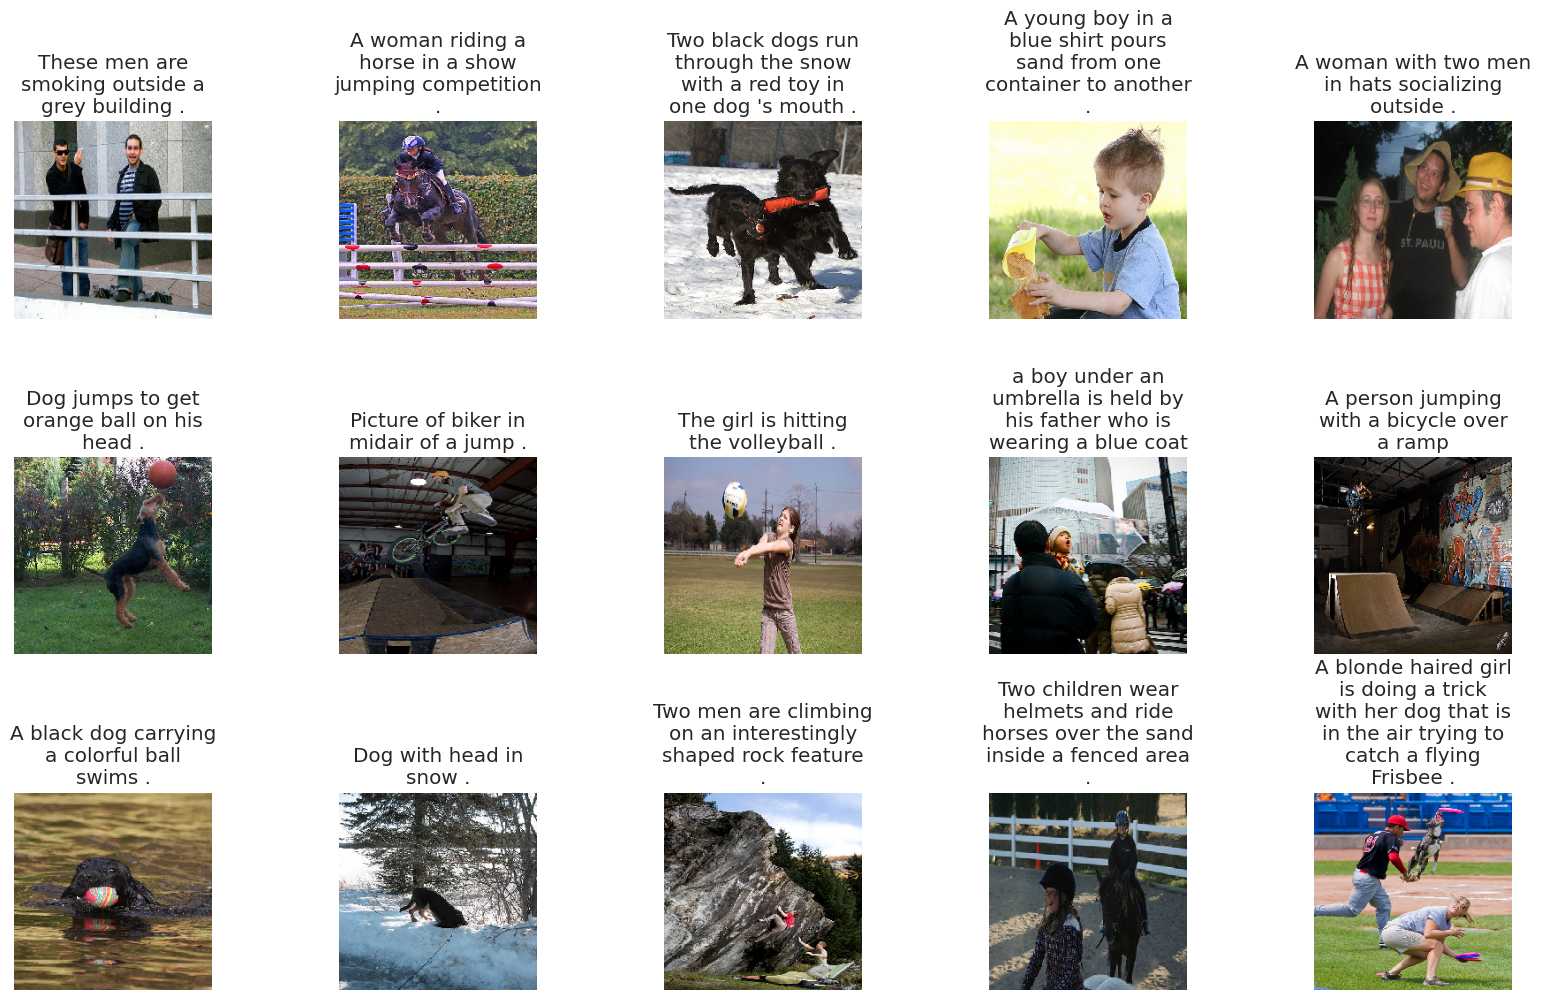

In [ ]:
display_images(data.sample(15))

## Getting Started

### Data Loading and Preprocessing
To train the image describer model, a dataset of images along with corresponding textual captions is required.
The Flickr8k dataset, a popular resource for image captioning tasks, is used. The first step involves loading and preprocessing this data to ensure it's in a format suitable for training the models.

**Data loading** involves parsing image files and corresponding caption text files, followed by preprocessing steps such as resizing images and tokenizing captions.

The spaCy library is utilized for tokenization and vocabulary building, ensuring efficient handling of textual data.
<img src='https://lena-voita.github.io/resources/lectures/word_emb/lookup_table.gif'>



### Dataset and DataLoader Setup

#### 1. `Vocabulary` Class

- **Description**: This class handles the construction of a vocabulary from a list of sentences. It tokenizes the sentences using spaCy's English tokenizer and assigns numerical indices to each token based on their frequency in the corpus.
- **Methods**:
  - `tokenizer_eng`: Tokenizes English text using spaCy's English tokenizer.
  - `build_vocabulary`: Builds the vocabulary based on the provided list of sentences.
  - `numericalize`: Converts text into numericalized tokens using the constructed vocabulary.

#### 2. `FlickrDataset` Class

- **Description**: This class represents the dataset for the Flickr image captions. It loads image paths and corresponding captions from a CSV file, preprocesses the captions, and builds a vocabulary using the `Vocabulary` class.
- **Parameters**:
  - `root_dir`: Root directory containing the images.
  - `captions_file`: Path to the CSV file containing image captions.
  - `transform`: Optional transform to be applied to the images.
  - `freq_threshold`: Frequency threshold for building the vocabulary.
- **Methods**:
  - `__len__`: Returns the total number of samples in the dataset.
  - `__getitem__`: Loads and preprocesses the image and its corresponding caption.

#### 3. `MyCollate` Class

- **Description**: This class defines the collate function for DataLoader, which handles padding of captions to ensure uniform batch sizes.
- **Parameters**:
  - `pad_idx`: Index of the padding token in the vocabulary.
- **Methods**:
  - `__call__`: Collates the batch by padding captions and stacking images.

#### 4. `get_loader` Function

- **Description**: This function creates DataLoader instances for training and validation sets. It splits the dataset into training and validation subsets and sets up DataLoader with appropriate parameters for batching and parallel data loading.
- **Parameters**:
  - `root_folder`: Root directory containing the images.
  - `annotation_file`: Path to the CSV file containing image captions.
  - `transform`: Transformations to be applied to the images.
  - `batch_size`: Batch size for DataLoader (default: 128).
  - `num_workers`: Number of worker processes for data loading (default: 8).
  - `shuffle`: Whether to shuffle the data (default: True).
  - `pin_memory`: Whether to pin memory for DataLoader (default: True).
- **Returns**: Train DataLoader, Validation DataLoader, and the dataset itself.

In [ ]:
# Load spaCy English model
spacy_eng = spacy.load("en_core_web_sm")

nlp = spacy.load("en_core_web_sm")

class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        for sentence in sentence_list:
            if not isinstance(sentence, str):
                sentence = str(sentence)
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

        idx = 4
        for word, freq in frequencies.items():
            if freq >= self.freq_threshold:
                self.stoi[word] = idx
                self.itos[idx] = word
                idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]


class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=10):
        self.root_dir = root_dir

        self.df  = pd.read_csv(captions_file)

        self.transform = transform

        # Get img, caption columns
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]

        # Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions.tolist())



    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return img, torch.tensor(numericalized_caption)


class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)

        return imgs, targets


def get_loader(
    root_folder,
    annotation_file,
    transform,
    batch_size=128,
    num_workers=8,
    shuffle=True,
    pin_memory=True,
):
    dataset = FlickrDataset(root_folder, annotation_file, transform=transform)

    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(0.8 * dataset_size)
    train_sampler = SubsetRandomSampler(indices[:split])
    Val_sampler = SubsetRandomSampler(indices[split:])

    # Create DataLoader
    pad_idx = dataset.vocab.stoi["<PAD>"]
    train_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        sampler=train_sampler,
        num_workers=num_workers,
        pin_memory=pin_memory,
        collate_fn=MyCollate(pad_idx=pad_idx),
    )

    val_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        sampler=Val_sampler,
        num_workers=num_workers,
        pin_memory=pin_memory,
        collate_fn=MyCollate(pad_idx=pad_idx),
    )

    return train_loader, val_loader, dataset


#Model Architectures

##EncoderCNN
The EncoderCNN component utilizes transfer learning with a pre-trained ResNet50 model to extract high-level features from input images. By using the weights of the parameters as per the pre-trained ResNet-50 no further training is done for the encoder. The encoder adapts to the specific task of image captioning while leveraging the generalizability learned from a diverse set of images.

##DecoderRNN
The DecoderRNN module decodes the image features obtained from the encoder into textual captions using a recurrent neural network architecture. An embedding layer maps discrete words to continuous vector representations, facilitating the modeling of semantic relationships between words. The LSTM (Long Short-Term Memory) layer captures temporal dependencies in the sequential data, ensuring coherent and contextually relevant caption generation.

##CNNtoRNN
The CNNtoRNN architecture integrates the EncoderCNN and DecoderRNN components into a unified model. This end-to-end approach allows for seamless image captioning by jointly optimizing the encoding and decoding processes, enhancing model performance and efficiency.

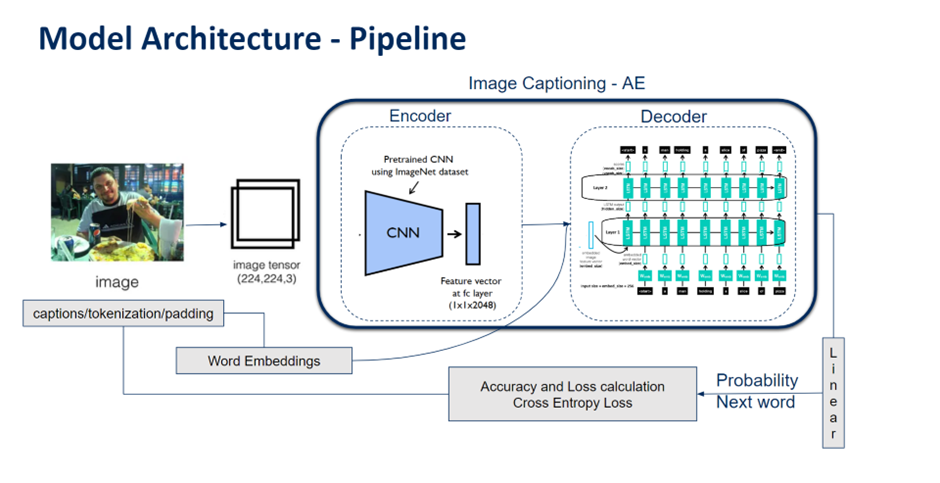

### PyTorch Model Architecture

#### 1. `EncoderCNN` Class

- **Description**: This class defines the encoder part of the CNN-to-RNN model. It utilizes a pre-trained ResNet-50 model as the feature extractor and modifies the classifier to output features of the desired size.

#### 2. `DecoderRNN` Class

- **Description**: This class defines the decoder part of the CNN-to-RNN model. It consists of an embedding layer, an LSTM layer, and a linear layer.

#### 3. `CNNtoRNN` Class

- **Description**: This class combines the encoder and decoder components to form the complete CNN-to-RNN model.
- **Caption Image Method**:
  - Accepts a single image and generates a caption for it using the trained model.
  - Implements a greedy decoding strategy to predict words iteratively until an `<EOS>` token is encountered or the maximum caption length is reached.

#### How to Use These Classes

- Import the necessary PyTorch libraries.
- Define an instance of the `CNNtoRNN` class, specifying the desired sizes for embeddings, hidden states, vocabulary, and LSTM layers.
- Train the model using appropriate training data and optimization techniques.
- Utilize the trained model for image captioning tasks by passing images through the `caption_image` method.

In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size, train_CNN=False):
        super(EncoderCNN, self).__init__()
        self.train_CNN = train_CNN
        # Use ResNet-50 as the feature extractor
        self.resnet = models.resnet50(pretrained=True)
        # Modify the classifier to match the desired output size (embed_size)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, embed_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, images):
        # Use the feature layer before the fully connected layer
        features = self.resnet(images)
        return self.dropout(self.relu(features))


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions))
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs


class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size)
        self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features, captions)
        return outputs

    def caption_image(self, image, vocabulary, max_length=50):
        result_caption = []

        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0)
            states = None

            for _ in range(max_length):
                hiddens, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                predicted = output.argmax(1)
                result_caption.append(predicted.item())
                x = self.decoderRNN.embed(predicted).unsqueeze(0)

                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break

        return [vocabulary.itos[idx] for idx in result_caption]


### PyTorch Helper Functions

#### 1. `calculate_accuracy` Function

The `calculate_accuracy` function computes the accuracy of model predictions. It takes the model's output predictions and compares them with the ground truth captions to determine the accuracy.

#### 2. `evaluate` Function

The `evaluate` function evaluates the performance of a trained model on a validation dataset. It takes the model, validation data loader, and criterion (loss function) as inputs. During evaluation, it calculates the average loss and accuracy over the entire validation dataset.



In [ ]:
# Function to calculate accuracy
def calculate_accuracy(outputs, captions):
    # Calculate accuracy
    predicted = outputs.argmax(2)
    non_pad_elements = (captions != dataset.vocab.stoi["<PAD>"]).sum()
    correct = (predicted == captions).sum()
    accuracy = correct / non_pad_elements
    return accuracy.item()

def evaluate(model, val_loader, criterion):
    model.eval()
    total_loss = 0
    total_accuracy = 0
    with torch.no_grad():
        for idx, (imgs, captions) in tqdm(
            enumerate(val_loader), total=len(val_loader), leave=False):
            imgs = imgs.to(device)
            captions = captions.to(device)

            outputs = model(imgs, captions[:-1])
            loss = criterion(
                outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1)
            )
            accuracy = calculate_accuracy(outputs, captions)

            total_loss += loss.item()
            total_accuracy += accuracy

    avg_loss = total_loss / len(val_loader)
    avg_accuracy = total_accuracy / len(val_loader)
    return avg_loss, avg_accuracy

### Training

**Training and Evaluation**

Model training involves optimizing the cross-entropy loss function between predicted and ground truth captions. The Adam optimizer is utilized for parameter updates, with learning rate scheduling to improve convergence. Evaluation metrics include both quantitative measures such as loss and accuracy, as well as qualitative assessments through human evaluation of generated captions. The model's performance is evaluated on held-out validation data to assess generalization and identify potential overfitting.



#### Training Setup

- **Description**: This code segment sets up the training process for the image captioning model. It defines the hyperparameters, initializes the model, criterion (loss function), and optimizer, and prepares the data loaders for training and validation.
- **Hyperparameters**:
  - `embed_size`: Size of the input and output feature embeddings.
  - `hidden_size`: Size of the hidden state in the LSTM.
  - `vocab_size`: Size of the vocabulary (number of unique words).
  - `num_layers`: Number of layers in the LSTM.
  - `learning_rate`: Learning rate for the optimizer.
  - `num_epochs`: Number of training epochs.
- **Model Initialization**:
  - Initializes the CNN-to-RNN model (`CNNtoRNN`) with specified hyperparameters and moves it to the appropriate device (GPU or CPU).
- **Optimizer**:
  - Adam optimizer is used with the specified learning rate.
- **Loss Function**:
  - Cross-entropy loss is used as the criterion, ignoring padding tokens.
- **Data Loaders**:
  - Creates train and validation data loaders using the `get_loader` function, which loads the Flickr dataset, performs necessary transformations on the images, and sets up batching and parallel data loading.

In [ ]:
spacy_eng = spacy.load("en_core_web_sm")

transform = transforms.Compose(
    [
        transforms.Resize((356, 356)),
        transforms.RandomCrop((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_loader, val_loader, dataset = get_loader(
    root_folder="/content/drive/MyDrive/MIE/MIE1517/Project_image_caption/flickr8k/Images",
    annotation_file="/content/drive/MyDrive/MIE/MIE1517/Project_image_caption/flickr8k/captions.txt",
    transform=transform,
    num_workers=2,
)

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 184MB/s]


Epoch [1/50], Loss: 3.7974, Accuracy: 0.3354, Val Loss: 3.2008, Val Accuracy: 0.3899


Epoch [2/50], Loss: 3.0526, Accuracy: 0.4031, Val Loss: 2.9117, Val Accuracy: 0.4151


Epoch [3/50], Loss: 2.8330, Accuracy: 0.4224, Val Loss: 2.7850, Val Accuracy: 0.4292


Epoch [4/50], Loss: 2.7094, Accuracy: 0.4340, Val Loss: 2.7032, Val Accuracy: 0.4373


Epoch [5/50], Loss: 2.6065, Accuracy: 0.4449, Val Loss: 2.6244, Val Accuracy: 0.4470


Epoch [6/50], Loss: 2.5285, Accuracy: 0.4518, Val Loss: 2.5801, Val Accuracy: 0.4511


Epoch [7/50], Loss: 2.4638, Accuracy: 0.4574, Val Loss: 2.5459, Val Accuracy: 0.4558


Epoch [8/50], Loss: 2.4104, Accuracy: 0.4626, Val Loss: 2.5185, Val Accuracy: 0.4586


Epoch [9/50], Loss: 2.3651, Accuracy: 0.4669, Val Loss: 2.4962, Val Accuracy: 0.4612


Epoch [10/50], Loss: 2.3262, Accuracy: 0.4710, Val Loss: 2.4884, Val Accuracy: 0.4625


Epoch [11/50], Loss: 2.2910, Accuracy: 0.4748, Val Loss: 2.4800, Val Accuracy: 0.4648


Epoch [12/50], Loss: 2.2637, Accuracy: 0.4775, Val Loss: 2.4697, Val Accuracy: 0.4653


Epoch [13/50], Loss: 2.2345, Accuracy: 0.4806, Val Loss: 2.4743, Val Accuracy: 0.4654


Epoch [14/50], Loss: 2.2087, Accuracy: 0.4834, Val Loss: 2.4650, Val Accuracy: 0.4680


Epoch [15/50], Loss: 2.1843, Accuracy: 0.4858, Val Loss: 2.4635, Val Accuracy: 0.4681


Epoch [16/50], Loss: 2.1640, Accuracy: 0.4873, Val Loss: 2.4663, Val Accuracy: 0.4677


Epoch [17/50], Loss: 2.1419, Accuracy: 0.4902, Val Loss: 2.4702, Val Accuracy: 0.4683


Epoch [18/50], Loss: 2.1233, Accuracy: 0.4917, Val Loss: 2.4779, Val Accuracy: 0.4672


Epoch [19/50], Loss: 2.1032, Accuracy: 0.4937, Val Loss: 2.4757, Val Accuracy: 0.4681


Epoch [20/50], Loss: 2.0856, Accuracy: 0.4957, Val Loss: 2.4799, Val Accuracy: 0.4673


Epoch [21/50], Loss: 2.0692, Accuracy: 0.4980, Val Loss: 2.4846, Val Accuracy: 0.4692


Epoch [22/50], Loss: 2.0545, Accuracy: 0.4999, Val Loss: 2.4956, Val Accuracy: 0.4676


Epoch [23/50], Loss: 2.0396, Accuracy: 0.5007, Val Loss: 2.5008, Val Accuracy: 0.4686


Epoch [24/50], Loss: 2.0237, Accuracy: 0.5028, Val Loss: 2.5027, Val Accuracy: 0.4674


Epoch [25/50], Loss: 2.0109, Accuracy: 0.5048, Val Loss: 2.5111, Val Accuracy: 0.4668


Epoch [26/50], Loss: 1.9988, Accuracy: 0.5055, Val Loss: 2.5239, Val Accuracy: 0.4666


Epoch [27/50], Loss: 1.9841, Accuracy: 0.5077, Val Loss: 2.5298, Val Accuracy: 0.4654


Epoch [28/50], Loss: 1.9717, Accuracy: 0.5094, Val Loss: 2.5395, Val Accuracy: 0.4657


Epoch [29/50], Loss: 1.9607, Accuracy: 0.5115, Val Loss: 2.5387, Val Accuracy: 0.4676


Epoch [30/50], Loss: 1.9499, Accuracy: 0.5112, Val Loss: 2.5482, Val Accuracy: 0.4651


Epoch [31/50], Loss: 1.9383, Accuracy: 0.5136, Val Loss: 2.5631, Val Accuracy: 0.4643


Epoch [32/50], Loss: 1.9275, Accuracy: 0.5152, Val Loss: 2.5631, Val Accuracy: 0.4666


Epoch [33/50], Loss: 1.9184, Accuracy: 0.5162, Val Loss: 2.5785, Val Accuracy: 0.4658


Epoch [34/50], Loss: 1.9079, Accuracy: 0.5181, Val Loss: 2.5851, Val Accuracy: 0.4656


Epoch [35/50], Loss: 1.8984, Accuracy: 0.5189, Val Loss: 2.5919, Val Accuracy: 0.4628


Epoch [36/50], Loss: 1.8896, Accuracy: 0.5201, Val Loss: 2.5980, Val Accuracy: 0.4649


Epoch [37/50], Loss: 1.8814, Accuracy: 0.5215, Val Loss: 2.6113, Val Accuracy: 0.4627


Epoch [38/50], Loss: 1.8737, Accuracy: 0.5226, Val Loss: 2.6131, Val Accuracy: 0.4640


Epoch [39/50], Loss: 1.8648, Accuracy: 0.5239, Val Loss: 2.6119, Val Accuracy: 0.4639


Epoch [40/50], Loss: 1.8567, Accuracy: 0.5259, Val Loss: 2.6309, Val Accuracy: 0.4636


Epoch [41/50], Loss: 1.8501, Accuracy: 0.5257, Val Loss: 2.6438, Val Accuracy: 0.4624


Epoch [42/50], Loss: 1.8428, Accuracy: 0.5272, Val Loss: 2.6480, Val Accuracy: 0.4611


Epoch [43/50], Loss: 1.8330, Accuracy: 0.5290, Val Loss: 2.6553, Val Accuracy: 0.4614


Epoch [44/50], Loss: 1.8258, Accuracy: 0.5297, Val Loss: 2.6585, Val Accuracy: 0.4632


Epoch [45/50], Loss: 1.8188, Accuracy: 0.5316, Val Loss: 2.6656, Val Accuracy: 0.4631


Epoch [46/50], Loss: 1.8133, Accuracy: 0.5318, Val Loss: 2.6855, Val Accuracy: 0.4618


Epoch [47/50], Loss: 1.8075, Accuracy: 0.5329, Val Loss: 2.6866, Val Accuracy: 0.4620


Epoch [48/50], Loss: 1.8020, Accuracy: 0.5334, Val Loss: 2.6901, Val Accuracy: 0.4629


Epoch [49/50], Loss: 1.7939, Accuracy: 0.5352, Val Loss: 2.7083, Val Accuracy: 0.4608


Epoch [50/50], Loss: 1.7896, Accuracy: 0.5358, Val Loss: 2.7142, Val Accuracy: 0.4608
Total training time: 216.30034043121339 Minutes


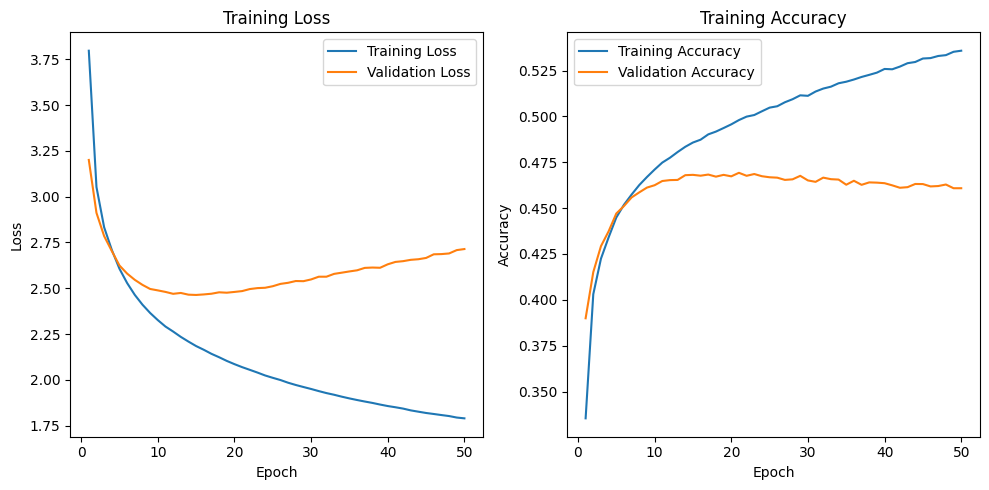

In [ ]:
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_CNN = False

# Hyperparameters
embed_size = 256
hidden_size = 256
vocab_size = len(dataset.vocab)
num_layers = 2
learning_rate = 3e-3
num_epochs = 50

# for tensorboard
writer = SummaryWriter("runs/flickr")
step = 0

# initialize model, loss etc
model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Only finetune the CNN
for name, param in model.encoderCNN.resnet.named_parameters():
    if "fc.weight" in name or "fc.bias" in name:
        param.requires_grad = True
    else:
        param.requires_grad = train_CNN

model.train()

# Lists to store loss and accuracy for plotting
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []


start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_accuracy = 0

    for idx, (imgs, captions) in tqdm(
        enumerate(train_loader), total=len(train_loader), leave=False
    ):
        imgs = imgs.to(device)
        captions = captions.to(device)

        outputs = model(imgs, captions[:-1])
        loss = criterion(
            outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1)
        )
        accuracy = calculate_accuracy(outputs, captions)

        total_loss += loss.item()
        total_accuracy += accuracy

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    avg_accuracy = total_accuracy / len(train_loader)

    val_loss, val_accuracy = evaluate(model, val_loader, criterion)

    writer.add_scalar("Training loss", avg_loss, global_step=epoch)
    writer.add_scalar("Training accuracy", avg_accuracy, global_step=epoch)
    writer.add_scalar("Validation loss", val_loss, global_step=epoch)
    writer.add_scalar("Validation accuracy", val_accuracy, global_step=epoch)

    # Save model weights after each epoch
    torch.save(model.state_dict(), f"fixed_model_epoch_{epoch + 1}.pt")

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    train_losses.append(avg_loss)
    train_accuracies.append(avg_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

end_time = time.time()
total_time = end_time - start_time
print(f"Total training time: {total_time*0.016} Minutes")


# Plotting loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Quantitative Results

---

Our models underwent training for 50 epochs, allowing for an in-depth exploration of their learning dynamics and performance across various stages of training.

- **Early Training Stages (Epoch 6):** At the onset of training, we observed the models adapting to the dataset without exhibiting signs of underfitting or overfitting. This initial phase laid the foundation for subsequent learning and model refinement.

- **Optimum Performance (Epoch 15):** By epoch 15, our models reached a stage where they achieved the lowest validation loss. This point signifies optimal convergence and generalization, showcasing the effectiveness of the training process in minimizing predictive errors.

- **Peak Validation Accuracy (Epoch 21):** Continuing training beyond epoch 15 led to further refinement, resulting in the highest validation accuracy observed at epoch 21. While validation accuracy improved, it's noteworthy that the gains were marginal compared to the optimal performance achieved at epoch 15.

Given the nature of our task, where accuracy is calculated based on word-by-word positional matches, the reported accuracies may appear low.

| Model                  | Epoch number | Train loss | Train accuracy | Validation loss | Validation accuracy |
|------------------------|--------------|------------|----------------|-----------------|---------------------|
| model_no_overfit       | 6            | 2.5285     | 0.4518         | 2.5801          | 0.4511              |
| model_lowest_val_loss  | 15           | 2.1843     | 0.4858         | 2.4635          | 0.4681              |
| model_highest_val_acc  | 21           | 2.0692     | 0.4980         | 2.4846          | 0.4692              |
---




In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embed_size = 256
hidden_size = 256
vocab_size = len(dataset.vocab)
num_layers = 2
learning_rate = 3e-3
num_epochs = 50

In [ ]:
model_highest_val_acc = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)
model_highest_val_acc.load_state_dict(torch.load('/content/drive/MyDrive/MIE/MIE1517/Project_image_caption/fixed_model_epoch_21.pt'))

In [ ]:
model_lowest_val_loss = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)
model_lowest_val_loss.load_state_dict(torch.load('/content/drive/MyDrive/MIE/MIE1517/Project_image_caption/fixed_model_epoch_15.pt'))

In [ ]:
model_no_overfit = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)
model_no_overfit.load_state_dict(torch.load('/content/drive/MyDrive/MIE/MIE1517/Project_image_caption/fixed_model_epoch_6.pt'))

## Model Performance Evaluation on the validation dataset

### Image Captioning Evaluation

#### `print_val_example` Function

- **Description**: This function evaluates the trained image captioning model on a single validation example. It takes the trained model and the index of the validation example as input and generates caption and audio.

#### How to Use

- Call the `print_val_example` function with the trained model and the index of the validation example to evaluate.
- The function will display the image, print the original caption, generate and print the caption predicted by the model, and play the generated caption as audio.

#### Example Usage

```python
print_val_example(model, 0)
```

This will evaluate the model on the first validation example.

In [ ]:
captions_df = pd.read_csv('/content/drive/MyDrive/MIE/MIE1517/Project_image_caption/flickr8k/captions.txt')
captions_df_len = len(captions_df)
indices = list(range(captions_df_len))
split = int(0.8 * captions_df_len)
val_captions_df = captions_df.iloc[indices[split:]].copy()
val_captions_df_len = len(val_captions_df)

In [ ]:
def print_val_example(model, indx):

    img_name = val_captions_df.iloc[indx]['image']

    transform = transforms.Compose([transforms.Resize((299, 299)),
                                    transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])
    model.eval()

    # Show the image
    img_loc = '/content/drive/MyDrive/MIE/MIE1517/Project_image_caption/flickr8k/Images/'+str(img_name)
    image = Image.open(img_loc).convert("RGB")
    plt.imshow(image)

    print('Original caption: ')
    print(captions_df[captions_df['image'] == img_name]['caption'].values)

    # Generate output
    img = transform(Image.open("/content/drive/MyDrive/MIE/MIE1517/Project_image_caption/flickr8k/Images/"+img_name).convert("RGB")).unsqueeze(0)
    caption_pred = " ".join(model.caption_image(img.to(device), dataset.vocab))
    cleaned_caption = caption_pred.replace('<SOS>', '').replace('<EOS>', '').strip()
    print('Generated caption: ')
    print(cleaned_caption)

    img_name_2 = img_name.replace('.jpg', '')
    tts = gTTS(text=cleaned_caption, lang='en')
    tts.save(img_name_2+'.mp3')

    # Play the audio directly in Colab
    return ipd.Audio(img_name_2+'.mp3')

#### **Model with Highest Validation Accuracy**

Original caption: 
['A group of young soccer players run down the field after the ball .'
 'Boys are playing soccer .'
 'The soccer player in the checked shirt is moving the ball pursued by the players on the other team .'
 'Two boys soccer teams play , one boy goes after the ball .'
 'Two teams of boys playing soccer .']
Generated caption: 
a boy in a baseball uniform is running on the field .


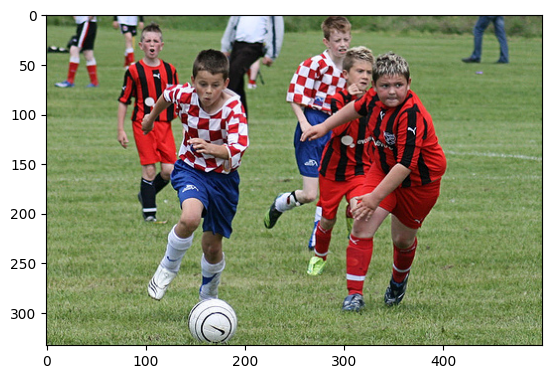

In [ ]:
random_integer = random.randint(0, val_captions_df_len)
print_val_example(model_highest_val_acc, random_integer)

Despite achieving the highest validation accuracy, the generated caption does not accurately capture the essence of the original captions. The model incorrectly identifies a single boy in a baseball uniform running on the field, which does not reflect the group dynamic or the specific activity of playing soccer described in the original captions. This discrepancy highlights the need for the model to better understand and represent the context and details conveyed in the original captions.

#### **Model with Lowest Validation Loss**

Original caption: 
['A boy plays in a pool with an inflatable toy .'
 'A boy swimming in a pool .' 'A child on a pink raft in a pool .'
 'A small boy swims with a pink floatation device in a swimming pool .'
 'Boy playing on a pink raft in a pool .']
Generated caption: 
a young boy is jumping into a swimming pool .


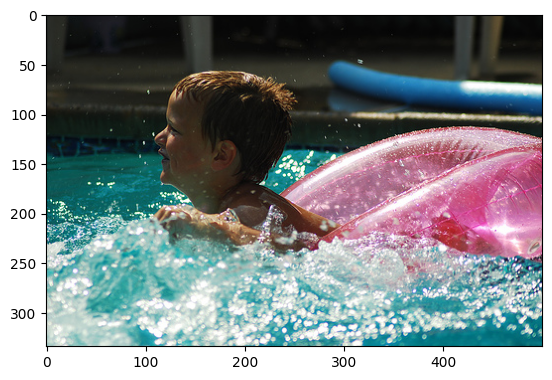

In [ ]:
random_integer = random.randint(0, val_captions_df_len)
print_val_example(model_lowest_val_loss, random_integer)

The generated caption closely aligns with the content of the original captions, depicting a young boy engaging in activities within a pool environment. However, it is important to note that the model's interpretation of the action as "jumping into a swimming pool" may slightly deviate from the original descriptions of playing with an inflatable toy and swimming. Nonetheless, the generated caption effectively captures the essence of the scene depicted in the image.

#### **Model with no overfit**

Original caption: 
['A dirt biker rides up a rocky hill on a motorized dirt bike .'
 'A man wearing a helmet and safety suit goes uphill over rocks on a dirt bike .'
 'A man wearing protective gear riding a dirt bike up a rocky hill .'
 'An off road motorbike climbs a rocky hill .'
 'A person on a motorcycle going uphill on rocky terrain']
Generated caption: 
a man in a red shirt is riding a bike on a dirt track .


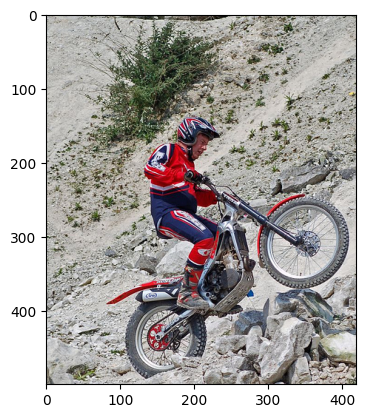

In [ ]:
random_integer = random.randint(0, val_captions_df_len)
print_val_example(model_no_overfit, random_integer)

While the generated caption mentions a person riding a bike on a dirt track, it does not accurately capture the specific details of the original captions, such as the rocky terrain and the presence of protective gear. This deviation suggests that the model may struggle to generate captions that precisely reflect the nuances and context provided in the original descriptions. Further refinement of the model's training process may be necessary to enhance its ability to generate more contextually relevant captions.


### Performance Summary of all models

---

- **Action Recognition:** The model demonstrates proficiency in recognizing actions depicted in the images, such as skateboarding, sitting, and running.

- **Contextual Understanding:** While the model accurately identifies key elements and actions within the scenes, it occasionally struggles with contextual understanding. This is evident from instances where the descriptions lack specific details or misinterpret certain aspects of the scene.

- **Accuracy vs. Detail:** The model tends to prioritize accuracy in identifying main subjects and actions over capturing finer details or contextual nuances. As a result, generated captions may lack detailed contextual information.

- **Object Counting:** In some cases, the model may misinterpret the number of objects or individuals present in the scene, leading to inaccuracies in the generated captions.

- **Room for Improvement:** Despite achieving notable accuracy in certain aspects, there is still room for improvement in enhancing the model's ability to generate detailed and contextually accurate captions for diverse scenes.

Overall, while the model demonstrates competency in recognizing and describing basic elements and actions within images, further refinement and training are necessary to enhance its contextual understanding and accuracy in generating detailed descriptions.

We prioritize minimal loss, as it indicates the model's ability to generate captions with the least deviation from ground truth annotations. Therefore, we selected the model trained at epoch 15 as our final model due to its superior performance in minimizing loss.




---

# Qualitative Results

#Evaluation on Novel Images


As part of our qualitative analysis, we subjected the model to a evaluation using a set of entirely new images sourced from the internet and captured during our class sessions.

Please note that none of these images were included in the training or validation datasets, ensuring that the model was not exposed to them during training.

This evaluation aims to assess the model's generalization capability and its ability to generate meaningful captions for unseen images, providing valuable insights into its performance under real-world conditions.



In [ ]:
def print_test_example(model, img_name):

    transform = transforms.Compose([transforms.Resize((299, 299)),
                                    transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])
    model.eval()
    # Show the image
    img_loc = '/content/drive/MyDrive/MIE/MIE1517/Project_image_caption/test_images/'+str(img_name)
    image = Image.open(img_loc).convert("RGB")
    plt.imshow(image)

    # Generate output
    img = transform(Image.open("/content/drive/MyDrive/MIE/MIE1517/Project_image_caption/test_images/"+img_name).convert("RGB")).unsqueeze(0)
    caption_pred = " ".join(model.caption_image(img.to(device), dataset.vocab))
    cleaned_caption = caption_pred.replace('<SOS>', '').replace('<EOS>', '').strip()
    print('Generated caption: ')
    print(cleaned_caption)

    img_name_2 = img_name.replace('.jpg', '')
    tts = gTTS(text=cleaned_caption, lang='en')
    tts.save(img_name_2+'.mp3')

    # Play the audio directly in Colab
    return ipd.Audio(img_name_2+'.mp3')

Generated caption: 
a man in a red shirt is riding a bike on a dirt track .


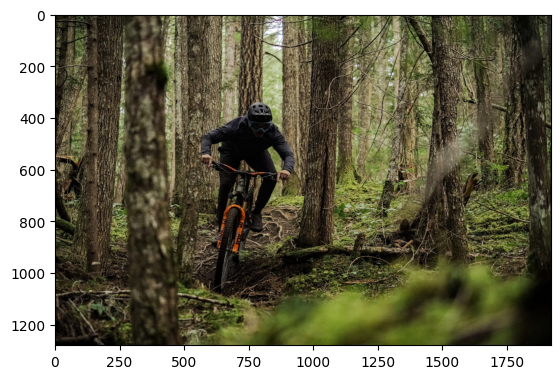

In [ ]:
print_test_example(model_lowest_val_loss, 'test_bike.jpg')

Generated caption: 
a young boy wearing a red shirt is running on the grass .


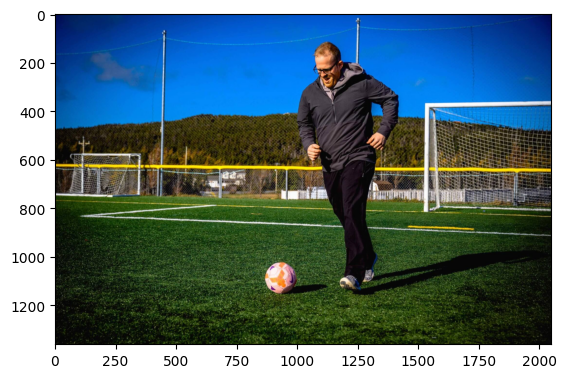

In [ ]:
print_test_example(model_lowest_val_loss, 'soccer.jpg')

Generated caption: 
a man in a black shirt and a white shirt is standing in front of a crowd of people .


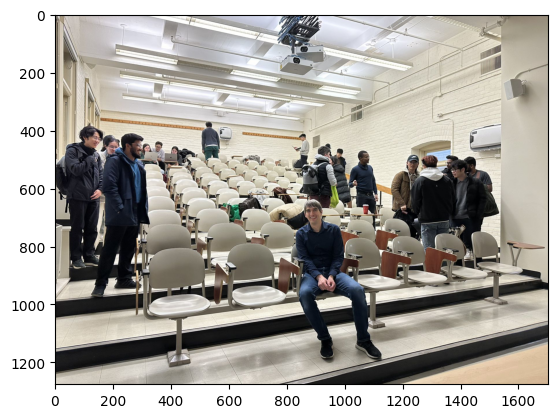

In [ ]:
print_test_example(model_lowest_val_loss, 'class.jpg')

Generated caption: 
a man and a woman are sitting on a bench and smiling .


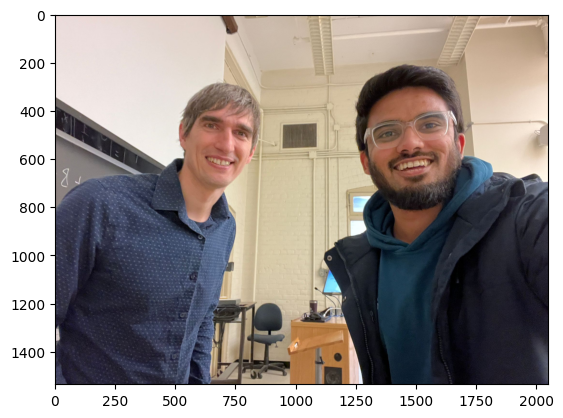

In [ ]:
print_test_example(model_lowest_val_loss, 'Sinisa_Abdullah.jpg')

## Results: Qualitative Analysis

The qualitative analysis involved evaluating the model's performance on a set of entirely new images not seen during training. Here are the results of the evaluation:


1. **Image 1:**
   - **Generated Caption:** "A man in a red shirt is riding a bike on a dirt track."
   - **Observation:** While the generated caption correctly identifies a man riding a bike, it misclassified the color of the shirt. This suggests that the model might prioritize the recognition of objects and actions over the identification of colors.

2. **Image 2:**
   - **Generated Caption:** "A young boy wearing a red shirt is running on the grass."
   - **Observation:** The generated caption correctly identifies the action of running and the presence of grass. However, it inaccurately describes a man as a 'young boy' and may misrepresent the color of the shirt. Moreover, it fails to recognize and include the activity of playing soccer depicted in the image. This omission suggests the caption lacks specific details concerning both the activity taking place and the accurate age group of the individual in the image.

3. **Image 3:**
   - **Generated Caption:** "A man in a black shirt and a white shirt is standing in front of a crowd of people."
   - **Observation:** The generated caption accurately identifies the presence of people standing and a crowd. However, it fails to capture a crucial detail: a man sitting. This omission suggests that, in scenarios involving a person, the token 'standing' may be disproportionately favored over others, indicating a limited variety in the model's generated captions.

4. **Image 4:**
   - **Generated Caption:** "A man and a woman are sitting on a bench and smiling."
   - **Observation:** The generated caption fails to accurately describe the scene, as it includes a woman sitting on a bench instead of two men standing in a classroom. This highlights a limitation in the model's ability to capture contextual details accurately.

Overall, the qualitative evaluation reveals both strengths and weaknesses in the model's ability to generate accurate and contextually relevant captions for novel images. Further refinement and fine-tuning of the model may be necessary to improve its performance in capturing nuanced details and contextual nuances.



---

#Testing on New Images from Youtube Video

To further assess the generalization ability of our final model, we tested it on new images frames captured from YouTube videos.

#### video 1


Generated caption: 
a dog is running through a field of grass .


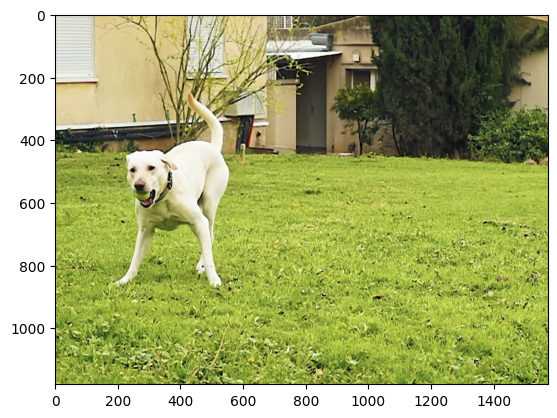

In [ ]:
print_test_example(model_lowest_val_loss, 'video_dog_2.jpg')

Generated caption: 
a dog is running through a field of grass .


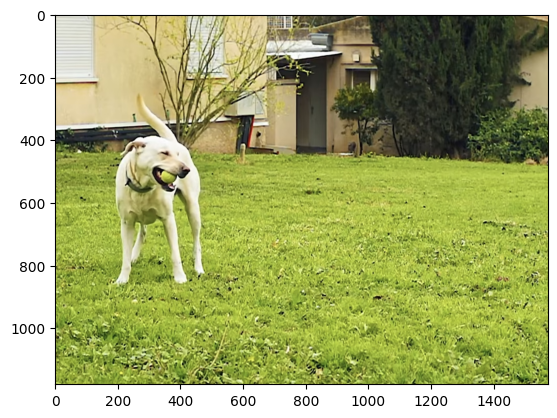

In [ ]:
print_test_example(model_lowest_val_loss, 'video_dog_3.jpg')

#### video 2

Generated caption: 
a dog is jumping over a hurdle .


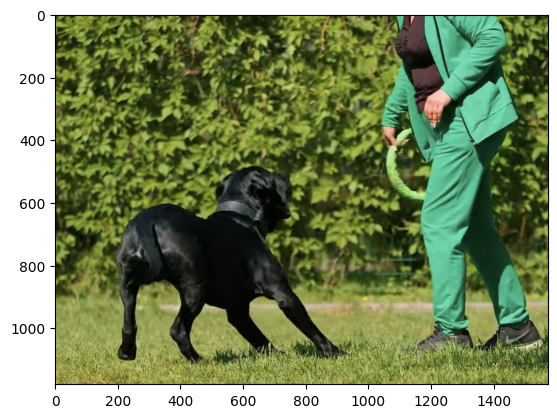

In [ ]:
print_test_example(model_lowest_val_loss, 'video_dog_play_1.jpg')

Generated caption: 
a dog is running through a field of grass .


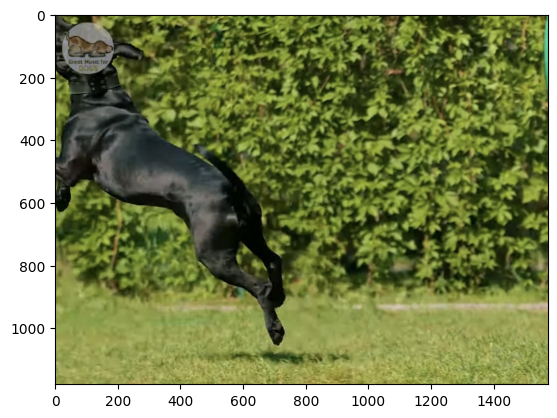

In [ ]:
print_test_example(model_lowest_val_loss, 'video_dog_play_2.jpg')

Generated caption: 
a dog is running through a field of grass .


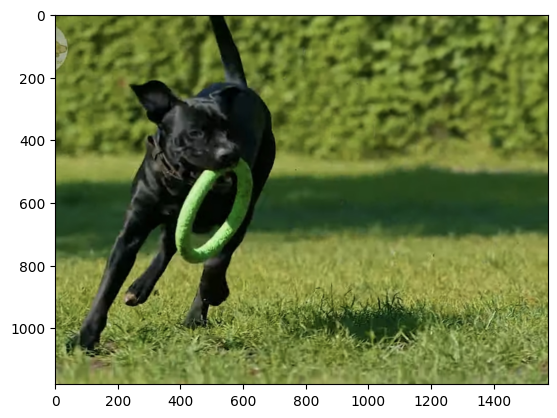

In [ ]:
print_test_example(model_lowest_val_loss, 'video_dog_play_4.jpg')

The generated captions for such dog centric image frames sourced from different videos :

1. **Video 1 image analysis**

  **Image 1: A Dog Jumping with the ball**
   - **Generated Caption:** "A dog is running through a field of grass."
   - **Analysis:** While the model correctly identifies the presence of a dog and the action of running, it lacks specificity regarding other elements in the scene, such as the the ball in the dog's mouth.

2. **Video 2 image analysis**

  **Image 2: A Dog Running Through a Field of Grass and carrying ring toy**
   - **Generated Caption:** "A dog is running through a field of grass."
   - **Analysis:** Similarly, the model accurately describes the main subject dog and action running, but lacks finer details about the activity of playing with a ring toy.

Despite producing correct captions, the model's descriptions lack detailed contextual information. This limitation highlights areas for potential improvement in future iterations of the model.

---

#### video 3


Generated caption: 
a man in a red shirt is skateboarding on a skateboard .


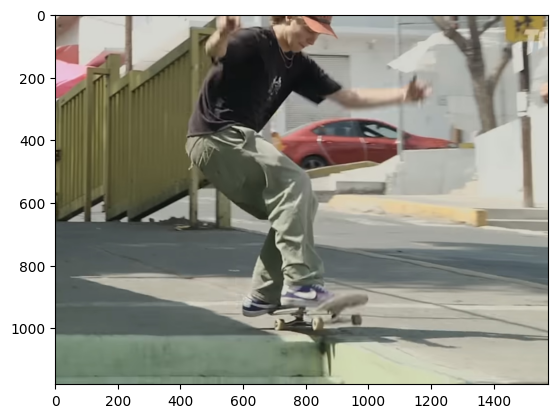

In [ ]:
print_test_example(model_lowest_val_loss, 'video_skateboarding_1.jpg')

Generated caption: 
a man and a woman are sitting on a bench in front of a <UNK> .


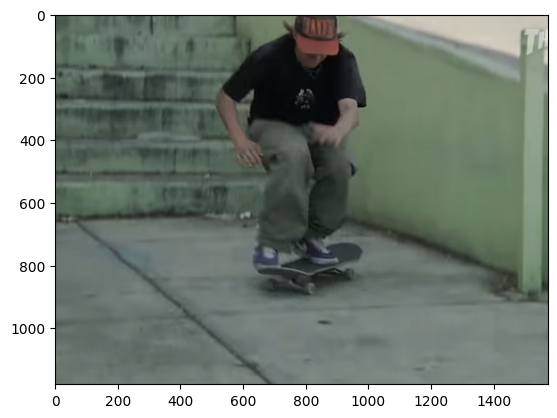

In [ ]:
print_test_example(model_lowest_val_loss, 'video_skateboarding_3.jpg')

Below are the generated captions and corresponding analyses for selected images of video 3:

1. **Image 1: A Man Skateboarding in a street**
   - **Generated Caption:** "A man in a red shirt is skateboarding on a skateboard."
   - **Analysis:** While the model correctly identifies the action of skateboarding and the setting as a restaurant, it fails to accurately describe the man's attire.

2. **Image 2: A Man and a Woman Sitting on a Bench**
   - **Generated Caption:** "A man and a woman are sitting on a bench in front of an unknown."
   - **Analysis:** The model fails to recognize that there is only one man in the picture and his action. However, since the man appears to be sitting, this likely triggers the generation of the token 'bench'.

These examples highlight both the strengths and limitations of our model in accurately describing complex scenes. While the model successfully identifies key elements and actions, it may struggle with finer contextual details and accurate object counts.


# Summary of The Project learnings and findings

Our model exhibited a noticeable bias, frequently generating certain texts, such as 'a dog running on grass', more than any other captions involving dogs, indicating a predisposition towards specific textual references. Overall, the generated captions reveal that the model struggles to comprehend the environment or the actions of humans depicted in the images, resulting in a limited variety of captions. However, it was surprising to find that the training time per epoch with LSTM was shorter than anticipated, taking less than 5 minutes. Interestingly, the model could still generate somewhat accurate captions, correctly identifying objects and actions in the images, despite its low validation accuracy.

Through this project, we learned the significance of utilizing temperature to diversify the output by incorporating words with lower probabilities. We recognized that while identifying objects in an image is relatively straightforward, generating coherent and contextually relevant captions is far more challenging. We discovered that employing pretrained word embeddings, adjusting the temperature setting, and exploring alternative evaluation metrics could significantly enhance performance in image captioning tasks. These insights underscore the complexity of text generation in image captioning and the importance of nuanced model tuning and evaluation strategies.

---
### Note on Reproducibility

The provided code offers a reliable solution for image captioning, with a focus on reproducibility. By following standard software development and machine learning practices, this code ensures that results are consistent, verifiable, and easily applicable across different scenarios.

1. **Modular Architecture**: The code's modular design separates functionality into distinct components, making it easy to understand, modify, or replace individual modules without impacting other parts of the system.

2. **Data Handling**: Supporting custom datasets and flexible data loading mechanisms, the code enables researchers to reproduce experiments using their own data. Clear instructions for data preprocessing and vocabulary building ensure standardized input data.

3. **Training and Evaluation**: Standard training and evaluation procedures, along with logging of training metrics such as loss and accuracy, facilitate transparent and reproducible research outcomes.

4. **Adaptability and Extensibility**: While providing a comprehensive solution, the code also encourages experimentation and adaptation to specific use cases. Researchers can modify hyperparameters, network architectures, or optimization strategies to explore different avenues and validate findings.

5. **Documentation and Best Practices**: Clear documentation, code comments, and adherence to best practices ensure that users understand the underlying principles and can follow established conventions for reproducible research.



---
# Challenges and Future Work


### Challenges Encountered

1. **Dataset Challenges:**
   - **Diverse Image Collection:** Acquiring a diverse and representative dataset with sufficient coverage of various visual scenes and contexts proved challenging. The quality and diversity of the dataset directly impact the model's ability to generalize and accurately describe novel images.
   - **Annotation Accuracy:** Ensuring accurate annotations for each image is crucial for training a reliable image captioning model. The manual annotation process can be time-consuming and prone to errors, leading to inconsistencies in the dataset.
   - **Subjectivity in Captions:** The subjective nature of human-generated captions introduces variability and ambiguity, making it challenging to establish ground truth annotations for training. Addressing these inconsistencies is essential to ensure the model learns meaningful associations between images and captions.

2. **Tokenizing Challenges:**
   - **Limited Vocabulary:** The vocabulary size directly affects the model's expressiveness and ability to capture the richness of natural language. A limited vocabulary may result in the model's inability to generate diverse and contextually appropriate captions, particularly for less common or specialized concepts.
   - **Tokenization Efficiency:** Efficient tokenization is critical for processing textual data and preparing it for input to the model. Optimal tokenization strategies are needed to balance computational efficiency with linguistic accuracy and coverage.

3. **Computational Challenges:**
   - **Resource Intensive Training:** Training deep learning models for image captioning requires substantial computational resources, including high-performance GPUs and significant training time. Efficient utilization of computational resources and optimization techniques are essential to reduce training time and costs.
   - **Scalability:** Scaling up model training to larger datasets or more complex architectures may exacerbate computational challenges, necessitating distributed training strategies and resource management techniques.

4. **Loss Function Challenges:**
   - **Relevance and Coherence:** Ensuring that generated captions are both relevant to the content of the image and coherent in their structure presents challenges. Balancing the trade-off between descriptive accuracy and linguistic fluency is crucial for optimizing the loss function and improving caption quality.
   - **Evaluation Criteria:** Designing effective evaluation metrics that capture the semantic relevance and contextual fidelity of generated captions is challenging. Traditional metrics such as BLEU may not fully capture the nuances of human language, highlighting the need for more sophisticated evaluation approaches.

### Future Work

1. **Real-Time Capabilities:**
   - **Efficiency Optimization:** Explore optimization techniques such as model compression, quantization, and hardware acceleration to improve inference speed and enable real-time captioning on resource-constrained devices.
   - **Streaming Captioning:** Extend the model's capabilities to caption video streams in real-time, enabling applications such as live event captioning and video content accessibility.

2. **Advanced Techniques:**
   - **Transfer Learning:** Investigate transfer learning techniques to leverage pre-trained models and domain-specific knowledge for image captioning tasks. Fine-tuning pre-trained models on task-specific datasets can expedite training and improve performance.
   - **Multimodal Fusion:** Explore multimodal fusion techniques to integrate information from both visual and textual modalities more effectively. Fusion mechanisms such as attention mechanisms and cross-modal embeddings can enhance the model's understanding of image-caption relationships.
   - **Adversarial Training:** Incorporate adversarial training frameworks to improve the robustness and diversity of generated captions. Adversarial learning can help mitigate issues such as mode collapse and promote the generation of more diverse and contextually relevant captions.

By addressing these challenges and exploring innovative approaches, we can further advance the image captioning and develop more robust and effective model for generating descriptive and contextually relevant captions.


---

# Summary of Related Work

---

In this section, we present a summary of related work on image captioning, referencing studies that utilize various architectures and techniques.

1. **DenseNet121 + LSTM with Teacher Forcing**
   - **Source:** [Medium Article](https://medium.com/@stepanulyanin/captioning-images-with-pytorch-bc592e5fd1a3)

2. **ResNet-50 + LSTM**
   - **Source:** [Medium Article](https://medium.com/@deepeshrishu09/automatic-image-captioning-with-pytorch-cf576c98d319)

3. **ResNet-18 + Transformer**
   - **Source:** [Kaggle Notebook](https://www.kaggle.com/code/dipanjandas96/image-caption-resnet-transformerdecoder-pytorch/notebook)

4. **mPLUG**
   - **Source:** [Papers with Code](https://paperswithcode.com/paper/mplug-effective-and-efficient-vision-language)

---


**Discussion:**

The image captioning task involves generating textual descriptions of images, which requires a nuanced understanding of both visual and linguistic content. Various approaches have been explored in the literature to address this challenge, primarily focusing on encoder-decoder architectures with CNNs as encoders and RNNs or Transformers as decoders.

One notable aspect of these architectures is their utilization of transfer learning techniques, leveraging pretrained CNNs to extract meaningful features from images. This allows the models to benefit from the rich representations learned from large-scale image datasets such as ImageNet. Additionally, fine-tuning these pretrained CNNs on specific captioning datasets helps tailor the features to the task at hand, improving the model's performance.

Furthermore, many studies incorporate teacher-forcing strategies during training to guide the decoder's generation process. Teacher-forcing involves feeding the ground truth tokens as inputs to the decoder during training, ensuring more stable and accurate learning. However, it's essential to balance the use of teacher-forcing with techniques like scheduled sampling to prevent over-reliance on ground truth tokens and encourage the model to generate diverse and coherent captions.

The emergence of advanced architectures like mPLUG demonstrates the ongoing innovation in image captioning research. By incorporating multimodal learning techniques such as attention mechanisms and cross-modal skip connections, mPLUG achieves impressive results in generating descriptive and contextually relevant captions. These techniques enable the model to focus on salient regions of the image and incorporate cross-modal information effectively, leading to more accurate and informative captions.

In summary, image captioning is a complex task that requires a combination of computer vision and natural language processing techniques. While current approaches have shown promising results, there is still room for improvement, particularly in capturing fine-grained details and contextual understanding. Continued research and innovation in this field are essential for advancing the state-of-the-art in image captioning and unlocking its full potential in various applications.

---
---